In [57]:
import matplotlib.pyplot as plt  # 画图模块
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import scipy.stats as stats # 统计模块
import scipy
from datetime import datetime # 时间模块
from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
import statsmodels.formula.api as smf  # OLS regression
import pyreadr # read RDS file
from matplotlib import style
import matplotlib.dates as mdates
from pandas._libs.tslibs.offsets import MonthEnd

# from matplotlib.font_manager import FontProperties # 作图中文
# from pylab import mpl
# mpl.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['font.family'] = 'Times New Roman'

#输出矢量图 渲染矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

#设置行不限制数量
#pd.set_option('display.max_rows',None)

#设置列不限制数量
pd.set_option('display.max_columns', None)

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'PingFang HK', 'STHeiti', 'SimHei'] # Mac系统支持的中文字体
plt.rcParams['axes.unicode_minus'] = False # 正确显示负号

# Risk-Free Rate

In [58]:
# Load Risk Free Rate
riskfree = pd.read_csv('Data/TRD_Nrrate2024.csv')
riskfree_mon = riskfree[['Clsdt', 'Nrrmtdt']].dropna()
riskfree_mon = riskfree_mon.drop([0,1])
riskfree_mon['month'] = pd.to_datetime(riskfree_mon['Clsdt'])+MonthEnd(0)
riskfree_mon['rfmonth'] = riskfree_mon['Nrrmtdt'].astype(float) / 100
riskfree_mon = riskfree_mon.groupby('month').agg({'rfmonth':'mean'}).reset_index()
riskfree_mon

,month,rfmonth
0,1990-12-31,0.006930
1,1991-01-31,0.006930
2,1991-02-28,0.006930
3,1991-03-31,0.006930
4,1991-04-30,0.006651
...,...,...
404,2024-08-31,0.001118
405,2024-09-30,0.001118
406,2024-10-31,0.001118
407,2024-11-30,0.001118


# 个股月收益率

- Stkcd [证券代码] - 以上交所、深交所公布的证券代码为准
- Trdmnt [交易月份] - 以YYYY-MM表示
- Opndt [月开盘日期] - 月第一个交易日。以DD表示，为OPNPRC的所在日，“DD”＝本月无交易
- Mopnprc [月开盘价] - 月第一个交易日的开盘价。
- Clsdt [月收盘日期] - 月最后一个交易日。以DD表示，为CLSPRC的所在日，“DD”＝本月无交易
- Mclsprc [月收盘价] - 月最后一个交易日的收盘价。
- Mnshrtrd [月个股交易股数] - 月内该股票的交易数量。计算公式为：月开盘日期与交易日期期间内日成交量之和。
- Mnvaltrd [月个股交易金额] - 月内该股票的交易金额。计算公式为：月开盘日期与交易日期期间内日成交额之和。A股以人民币元计，上海B以美元计，深圳B以港币计。
- Msmvosd [月个股流通市值] - 个股的流通股数与月收盘价的乘积。计算公式为：个股的流通股数与月收盘价的乘积。 A股以人民币元计，上海B以美元计，深圳B以港币计，注意单位是千
- Msmvttl [月个股总市值] - 个股的发行总股数与月收盘价的乘积。计算公式为：个股的发行总股数与月收盘价的乘积，A股以人民币元计，上海B股以美元计，深圳B股以港币计，注意单位是千
- Ndaytrd [月交易天数] - 计算公式为：月内实际交易的天数之和。
- Mretwd [考虑现金红利再投资的月个股回报率] - 字段说明见说明书“周、月、年个股回报率的计算方法”。
- Mretnd [不考虑现金红利再投资的月个股回报率] - 字段说明见说明书“周、月、年个股回报率的计算方法”。
- Markettype [市场类型] - 1=上证A股市场 (不包含科创板），2=上证B股市场，4=深证A股市场（不包含创业板），8=深证B股市场，16=创业板， 32=科创板，64=北证A股市场。
- Capchgdt [最新股本变动日期] - 上市公司最近一次股本发生变化的日期
- Ahshrtrd_M [月盘后成交总量] - 月科创板股票盘后总成交量。计算公式为：月开盘日期与交易日期期间内日盘后成交量之和。
- Ahvaltrd_M [月盘后成交总额] - 月科创板股票盘后总成交额。计算公式为：月开盘日期与交易日期期间内日盘后成交额之和。

In [59]:
ret_mon = (
    pd.read_csv('Data/TRD_Mnth199012-202412.csv')
    [[
        'Stkcd',
        'Trdmnt',
        'Ndaytrd',
        'Msmvosd',
        'Msmvttl',
        'Mretwd',
        'Markettype',
    ]]
)
ret_mon = ret_mon.rename(
    columns={
        'Trdmnt': 'month',
        'Ndaytrd': 'Freq',
        'Msmvosd': 'floatingvalue',
        'Msmvttl': 'totalvalue',
        'Mretwd': 'Return',
    }
)
ret_mon['floatingvalue'] = pd.to_numeric(ret_mon['floatingvalue'], errors='coerce') * 1000
ret_mon['totalvalue'] = pd.to_numeric(ret_mon['totalvalue'], errors='coerce') * 1000
ret_mon['Return'] = pd.to_numeric(ret_mon['Return'], errors='coerce')
ret_mon['month'] = pd.to_datetime(ret_mon['month']).dt.to_period('M').dt.to_timestamp('M')
ret_mon['Freq'] = pd.to_numeric(ret_mon['Freq'], errors='coerce')
ret_mon['Markettype'] = pd.to_numeric(ret_mon['Markettype'], errors='coerce')
ret_mon = ret_mon[ret_mon['Markettype'].isin([1, 4, 16])]
ret_mon = ret_mon.merge(riskfree_mon, on='month', how='left')
ret_mon = ret_mon.sort_values(['Stkcd', 'month']).reset_index(drop=True)
ret_mon['Stkcd'] = ret_mon['Stkcd'].astype(str).str.zfill(6)
ret_mon['ret'] = ret_mon['Return'] - ret_mon['rfmonth']
# 计算每个公司从上市开始的月份数（使用日历月份）
# 首先获取每个公司最早的交易月份作为上市月份
first_month = ret_mon.groupby('Stkcd')['month'].transform('min')
# 计算每个观测值距离上市月份的月份差
ret_mon['listing_month'] = ((ret_mon['month'].dt.year - first_month.dt.year) * 12 + 
                           (ret_mon['month'].dt.month - first_month.dt.month) + 1)
ret_mon

,Stkcd,month,Freq,floatingvalue,totalvalue,Return,Markettype,rfmonth,ret,listing_month
0,000001,1991-04-30,20,1.157520e+09,2.118487e+09,NaN,4,0.006651,NaN,1
1,000001,1991-05-31,24,1.016010e+09,1.859497e+09,-0.122253,4,0.006092,-0.128345,2
2,000001,1991-06-30,23,9.007350e+08,1.648521e+09,-0.113459,4,0.006092,-0.119551,3
3,000001,1991-07-31,16,7.828100e+08,1.432695e+09,-0.130921,4,0.006092,-0.137013,4
4,000001,1991-08-31,15,6.748338e+08,1.346275e+09,-0.411588,4,0.006092,-0.417680,5
...,...,...,...,...,...,...,...,...,...,...
769034,605599,2024-08-31,22,6.300920e+09,8.353334e+09,-0.065274,1,0.001118,-0.066392,36
769035,605599,2024-09-30,19,9.247778e+09,9.247778e+09,0.107076,1,0.001118,0.105958,37
769036,605599,2024-10-31,18,8.283334e+09,8.283334e+09,-0.104289,1,0.001118,-0.105407,38
769037,605599,2024-11-30,21,8.944445e+09,8.944445e+09,0.079812,1,0.001118,0.078694,39


接下来的任务是在数据中添加列为未来的收益率：例如t+1月、。。。、t+12月的收益率

In [60]:
# 为每个股票创建未来1-12个月的收益率
for i in range(1, 13):
    # 创建一个临时列，将月份向前移动i个月，使用月末日期
    ret_mon[f'future_month_{i}'] = ret_mon['month'].dt.to_period('M').dt.to_timestamp('M')
    ret_mon[f'future_month_{i}'] = ret_mon[f'future_month_{i}'] + pd.DateOffset(months=i)+MonthEnd(0)
    
    # 使用merge来匹配未来月份的收益率，确保使用月末日期进行匹配
    future_returns = ret_mon[['Stkcd', 'month', 'ret']].copy()
    future_returns['month'] = future_returns['month'].dt.to_period('M').dt.to_timestamp('M')
    future_returns = future_returns.rename(
        columns={'month': f'future_month_{i}', 'ret': f'ret_t{i}'}
    )
    
    # 将未来收益率合并到原始数据中
    ret_mon = ret_mon.merge(
        future_returns,
        on=['Stkcd', f'future_month_{i}'],
        how='left'
    )
    
    # 删除临时列
    ret_mon = ret_mon.drop(columns=[f'future_month_{i}'])

# 显示结果
ret_mon

,Stkcd,month,Freq,floatingvalue,totalvalue,Return,Markettype,rfmonth,ret,listing_month,ret_t1,ret_t2,ret_t3,ret_t4,ret_t5,ret_t6,ret_t7,ret_t8,ret_t9,ret_t10,ret_t11,ret_t12
0,000001,1991-04-30,20,1.157520e+09,2.118487e+09,NaN,4,0.006651,NaN,1,-0.128345,-0.119551,-0.137013,-0.417680,-0.039425,0.849080,0.016213,0.061181,0.055237,0.006749,0.239957,0.471835
1,000001,1991-05-31,24,1.016010e+09,1.859497e+09,-0.122253,4,0.006092,-0.128345,2,-0.119551,-0.137013,-0.417680,-0.039425,0.849080,0.016213,0.061181,0.055237,0.006749,0.239957,0.471835,0.167934
2,000001,1991-06-30,23,9.007350e+08,1.648521e+09,-0.113459,4,0.006092,-0.119551,3,-0.137013,-0.417680,-0.039425,0.849080,0.016213,0.061181,0.055237,0.006749,0.239957,0.471835,0.167934,-0.076888
3,000001,1991-07-31,16,7.828100e+08,1.432695e+09,-0.130921,4,0.006092,-0.137013,4,-0.417680,-0.039425,0.849080,0.016213,0.061181,0.055237,0.006749,0.239957,0.471835,0.167934,-0.076888,0.079622
4,000001,1991-08-31,15,6.748338e+08,1.346275e+09,-0.411588,4,0.006092,-0.417680,5,-0.039425,0.849080,0.016213,0.061181,0.055237,0.006749,0.239957,0.471835,0.167934,-0.076888,0.079622,-0.101487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769034,605599,2024-08-31,22,6.300920e+09,8.353334e+09,-0.065274,1,0.001118,-0.066392,36,0.105958,-0.105407,0.078694,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769035,605599,2024-09-30,19,9.247778e+09,9.247778e+09,0.107076,1,0.001118,0.105958,37,-0.105407,0.078694,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769036,605599,2024-10-31,18,8.283334e+09,8.283334e+09,-0.104289,1,0.001118,-0.105407,38,0.078694,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769037,605599,2024-11-30,21,8.944445e+09,8.944445e+09,0.079812,1,0.001118,0.078694,39,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 数据过滤

- 删除交易较少的股票 Freq
- 删除IPO不足12个月/6个月的股票
- 删除Return缺失的股票
- 过去12个月交易日不足120天的股票

In [61]:
# 计算过去12个月的交易频率总和
ret_mon['past_12m_freq'] = ret_mon['Freq']  # 初始化为本月频率

# 对每个股票计算过去11个月（加上本月共12个月）的交易频率总和
for i in range(1, 12):  # 改为1到11，因为本月已经包含在初始值中: 1-11已经
    # 创建临时列，将月份向后移动i个月
    ret_mon[f'past_month_{i}'] = ret_mon['month'].dt.to_period('M').dt.to_timestamp('M')
    ret_mon[f'past_month_{i}'] = ret_mon[f'past_month_{i}'] - pd.DateOffset(months=i)+MonthEnd(0)
    
    # 使用merge来匹配过去月份的Freq
    past_freq = ret_mon[['Stkcd', 'month', 'Freq']].copy()
    past_freq['month'] = past_freq['month'].dt.to_period('M').dt.to_timestamp('M')
    past_freq = past_freq.rename(
        columns={'month': f'past_month_{i}', 'Freq': f'freq_t{i}'}
    )
    
    # 将过去Freq合并到原始数据中
    ret_mon = ret_mon.merge(
        past_freq,
        on=['Stkcd', f'past_month_{i}'],
        how='left'
    )
    
    # 累加到past_12m_freq中
    ret_mon['past_12m_freq'] += ret_mon[f'freq_t{i}'].fillna(0)
    
    # 删除临时列
    ret_mon = ret_mon.drop(columns=[f'past_month_{i}', f'freq_t{i}'])

print("过去12个月（含本月）交易频率总和的计算完成")
print(ret_mon[['Stkcd', 'month', 'past_12m_freq']].head())


过去12个月（含本月）交易频率总和的计算完成
    Stkcd      month  past_12m_freq
0  000001 1991-04-30           20.0
1  000001 1991-05-31           44.0
2  000001 1991-06-30           67.0
3  000001 1991-07-31           83.0
4  000001 1991-08-31           98.0


In [62]:
ret_mon = ret_mon[
    (ret_mon['past_12m_freq'] > 120) & 
    (ret_mon['listing_month'] > 12) & 
    (ret_mon['Freq'] > 7)
]
ret_mon.dropna(subset=['Return'], inplace=True)
ret_mon

,Stkcd,month,Freq,floatingvalue,totalvalue,Return,Markettype,rfmonth,ret,listing_month,ret_t1,ret_t2,ret_t3,ret_t4,ret_t5,ret_t6,ret_t7,ret_t8,ret_t9,ret_t10,ret_t11,ret_t12,past_12m_freq
12,000001,1992-04-30,22,2.599445e+09,5.185820e+09,0.477927,4,0.006092,0.471835,13,0.167934,-0.076888,0.079622,-0.101487,0.075120,-0.110352,-0.047394,0.155788,0.092784,0.196362,-0.029902,0.018298,260.0
13,000001,1992-05-31,21,3.051816e+09,6.088287e+09,0.174026,4,0.006092,0.167934,14,-0.076888,0.079622,-0.101487,0.075120,-0.110352,-0.047394,0.155788,0.092784,0.196362,-0.029902,0.018298,-0.063961,257.0
14,000001,1992-06-30,22,2.835758e+09,5.657258e+09,-0.070796,4,0.006092,-0.076888,15,0.079622,-0.101487,0.075120,-0.110352,-0.047394,0.155788,0.092784,0.196362,-0.029902,0.018298,-0.063961,-0.086384,256.0
15,000001,1992-07-31,23,3.078823e+09,6.142166e+09,0.085714,4,0.006092,0.079622,16,-0.101487,0.075120,-0.110352,-0.047394,0.155788,0.092784,0.196362,-0.029902,0.018298,-0.063961,-0.086384,-0.090366,263.0
16,000001,1992-08-31,21,2.785120e+09,5.556236e+09,-0.095395,4,0.006092,-0.101487,17,0.075120,-0.110352,-0.047394,0.155788,0.092784,0.196362,-0.029902,0.018298,-0.063961,-0.086384,-0.090366,-0.047337,269.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769034,605599,2024-08-31,22,6.300920e+09,8.353334e+09,-0.065274,1,0.001118,-0.066392,36,0.105958,-0.105407,0.078694,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242.0
769035,605599,2024-09-30,19,9.247778e+09,9.247778e+09,0.107076,1,0.001118,0.105958,37,-0.105407,0.078694,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241.0
769036,605599,2024-10-31,18,8.283334e+09,8.283334e+09,-0.104289,1,0.001118,-0.105407,38,0.078694,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242.0
769037,605599,2024-11-30,21,8.944445e+09,8.944445e+09,0.079812,1,0.001118,0.078694,39,-0.014161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241.0


# Function

## 构造投资组合

In [63]:
def construct_anomaly_portfolio(data, sort_variable, n_groups=10, ascending=True, 
                               future_return_col='ret_t1', start_date=None, end_date=None,
                               weight_method='totalvalue'):
    """
    构造基于任意变量的异象投资组合
    
    参数:
    data: 包含股票数据的DataFrame
    sort_variable: 用于分组的变量名（字符串），如'totalvalue', 'floatingvalue'等
    n_groups: 分组数量，默认为10组
    ascending: 排序方向，True表示升序（小值在前），False表示降序（大值在前）
    future_return_col: 未来收益率列名，默认为'ret_t1'
    start_date: 样本起始时间，格式为'YYYY-MM-DD'或datetime
    end_date: 样本结束时间，格式为'YYYY-MM-DD'或datetime
    weight_method: 加权方法，可选：
                  - 'totalvalue': 总市值加权（默认）
                  - 'floatingvalue': 流通市值加权
                  - 'equal': 等权重
    
    返回:
    portfolio_returns: 包含各组合收益率的DataFrame
    """
    
    # 验证权重方法参数
    valid_weight_methods = ['totalvalue', 'floatingvalue', 'equal']
    if weight_method not in valid_weight_methods:
        raise ValueError(f"weight_method必须是以下之一: {valid_weight_methods}")
    
    # 时间筛选
    if start_date is not None:
        start_date = pd.to_datetime(start_date)
        data = data[data['month'] >= start_date]
    
    if end_date is not None:
        end_date = pd.to_datetime(end_date)
        data = data[data['month'] <= end_date]
    
    # 创建结果存储列表
    portfolio_results = []
    
    # 获取所有月份
    months = sorted(data['month'].unique())
    
    for month in months:
        # 获取当月数据
        month_data = data[data['month'] == month].copy()
        
        # 根据权重方法确定需要的列
        required_cols = [sort_variable, future_return_col]
        if weight_method in ['totalvalue', 'floatingvalue']:
            required_cols.append(weight_method)
        
        # 过滤掉缺失值
        month_data = month_data.dropna(subset=required_cols)
        
        if len(month_data) < n_groups:
            continue
            
        # 按指定变量分组
        try:
            month_data['rank'] = pd.qcut(month_data[sort_variable], 
                                       q=n_groups, 
                                       labels=False, 
                                       duplicates='drop')
        except ValueError:
            # 如果qcut失败（比如重复值太多），使用rank方法
            month_data['rank'] = pd.qcut(month_data[sort_variable].rank(method='first'), 
                                       q=n_groups, 
                                       labels=False)
        
        # 如果是降序排列，需要反转排名
        if not ascending:
            month_data['rank'] = n_groups - 1 - month_data['rank']
        
        # 计算每组的加权收益率
        group_returns = {}
        
        for group in range(n_groups):
            group_data = month_data[month_data['rank'] == group]
            
            if len(group_data) > 0:
                if weight_method == 'equal':
                    # 等权重
                    weighted_return = group_data[future_return_col].mean()
                else:
                    # 市值加权（总市值或流通市值）
                    weights = group_data[weight_method]
                    total_weight = weights.sum()
                    
                    if total_weight > 0:
                        weighted_return = (group_data[future_return_col] * weights).sum() / total_weight
                    else:
                        weighted_return = np.nan
                
                group_returns[f'Group_{group+1}'] = weighted_return
            else:
                group_returns[f'Group_{group+1}'] = np.nan
        
        # 计算多空组合收益率（买入第1组，卖出第n组）
        if f'Group_1' in group_returns and f'Group_{n_groups}' in group_returns:
            if not (pd.isna(group_returns[f'Group_1']) or pd.isna(group_returns[f'Group_{n_groups}'])):
                long_short_return = group_returns[f'Group_1'] - group_returns[f'Group_{n_groups}']
                group_returns['Long_Short'] = long_short_return
            else:
                group_returns['Long_Short'] = np.nan
        else:
            group_returns['Long_Short'] = np.nan
        
        # 添加月份信息
        group_returns['month'] = month
        portfolio_results.append(group_returns)
    
    # 转换为DataFrame
    portfolio_df = pd.DataFrame(portfolio_results)
    portfolio_df = portfolio_df.set_index('month').sort_index()
    
    # 移除非数值列
    numeric_cols = portfolio_df.select_dtypes(include=[np.number]).columns
    portfolio_df = portfolio_df[numeric_cols]
    
    return portfolio_df

## 组合分析函数

In [64]:
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.tsa.stattools import acf

# Newey-West调整的t统计量计算函数
def calculate_newey_west_tstat(returns, max_lags=None):
    """
    计算Newey-West调整的t统计量
    
    参数:
    returns: 收益率序列
    max_lags: 最大滞后期数，如果为None则自动选择
    
    返回:
    t_stat: Newey-West调整的t统计量
    nw_se: Newey-West标准误
    """
    
    returns = returns.dropna()
    n = len(returns)
    
    if n < 2:
        return np.nan, np.nan
    
    # 如果没有指定最大滞后期，使用常用的公式
    if max_lags is None:
        # Newey-West建议的滞后期选择：floor(4*(T/100)^(2/9))
        max_lags = int(np.floor(4 * (n / 100) ** (2/9)))
        max_lags = max(1, min(max_lags, n // 4))  # 确保滞后期合理
    
    # 构造回归：returns = alpha + error
    # 这里我们测试均值是否显著不为0
    X = np.ones((n, 1))  # 常数项
    y = returns.values.reshape(-1, 1)
    
    try:
        # 使用OLS估计
        model = sm.OLS(y, X)
        results = model.fit()
        
        # 计算Newey-West协方差矩阵
        nw_cov = cov_hac(results, nlags=max_lags)
        nw_se = np.sqrt(nw_cov[0, 0])
        
        # 计算t统计量
        mean_return = returns.mean()
        t_stat = mean_return / nw_se
        
        return t_stat, nw_se
        
    except:
        # 如果计算失败，返回传统t统计量
        mean_return = returns.mean()
        std_error = returns.std() / np.sqrt(n)
        t_stat = mean_return / std_error
        return t_stat, std_error
    
# 修改分析函数，显示使用的权重方法
def analyze_portfolio_performance(portfolio_df, portfolio_name="投资组合", 
                                  weight_method="totalvalue",
                                    start_date=None, end_date=None, 
                                    plot_cumulative=True, nw_lags=None):
    """
    分析投资组合的表现（包含权重方法信息）
    """
    
    # 时间筛选
    if start_date is not None:
        start_date = pd.to_datetime(start_date)
        portfolio_df = portfolio_df[portfolio_df.index >= start_date]
    
    if end_date is not None:
        end_date = pd.to_datetime(end_date)
        portfolio_df = portfolio_df[portfolio_df.index <= end_date]
    
    # 权重方法的中文描述
    weight_descriptions = {
        'totalvalue': '总市值加权',
        'floatingvalue': '流通市值加权',
        'equal': '等权重'
    }
    
    print(f"\n{'='*60}")
    print(f"{portfolio_name} 投资组合分析报告")
    print(f"加权方法: {weight_descriptions.get(weight_method, weight_method)}")
    print(f"分析期间: {portfolio_df.index.min().strftime('%Y-%m')} 至 {portfolio_df.index.max().strftime('%Y-%m')}")
    print(f"{'='*60}")
    
    # 其余分析代码与之前相同...
    # 基本统计信息
    print(f"\n=== 基本统计信息 ===")
    print(portfolio_df.describe())
    
    # 各组合平均收益率
    print(f"\n=== 各组合平均月收益率 ===")
    mean_returns = portfolio_df.mean()
    print(mean_returns)
    
    # 详细分析多空组合
    stats_dict = {}
    if 'Long_Short' in portfolio_df.columns:
        long_short_stats = portfolio_df['Long_Short'].dropna()
        if len(long_short_stats) > 0:
            # 计算各种统计指标
            mean_return = long_short_stats.mean()
            std_return = long_short_stats.std()
            annual_return = mean_return * 12
            annual_vol = std_return * np.sqrt(12)
            sharpe_ratio = mean_return / std_return if std_return > 0 else np.nan
            
            # 计算传统t统计量
            traditional_t_stat = mean_return / (std_return / np.sqrt(len(long_short_stats))) if std_return > 0 else np.nan
            
            # 计算Newey-West调整的t统计量
            nw_t_stat, nw_se = calculate_newey_west_tstat(long_short_stats, max_lags=nw_lags)
            
            win_rate = (long_short_stats > 0).mean()
            
            # 计算最大回撤
            cumulative_returns = (1 + long_short_stats).cumprod()
            running_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - running_max) / running_max
            max_drawdown = drawdown.min()
            
            print(f"\n=== 多空组合(Long_Short)详细统计 ===")
            print(f"观测数量: {len(long_short_stats)}")
            print(f"平均月收益率: {mean_return:.4f} ({mean_return*100:.2f}%)")
            print(f"年化收益率: {annual_return:.4f} ({annual_return*100:.2f}%)")
            print(f"年化波动率: {annual_vol:.4f} ({annual_vol*100:.2f}%)")
            print(f"夏普比率: {sharpe_ratio:.4f}")
            print(f"传统t统计量: {traditional_t_stat:.4f}")
            print(f"Newey-West t统计量: {nw_t_stat:.4f}")
            print(f"胜率: {win_rate:.4f} ({win_rate*100:.2f}%)")
            print(f"最大回撤: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")
            
            # 保存统计结果
            stats_dict = {
                'weight_method': weight_method,
                'observations': len(long_short_stats),
                'mean_return': mean_return,
                'annual_return': annual_return,
                'std_return': std_return,
                'annual_vol': annual_vol,
                'sharpe_ratio': sharpe_ratio,
                'traditional_t_stat': traditional_t_stat,
                'newey_west_t_stat': nw_t_stat,
                'win_rate': win_rate,
                'max_drawdown': max_drawdown
            }
            
            if plot_cumulative:
                plot_portfolio_performance(portfolio_df, f"{portfolio_name} ({weight_descriptions.get(weight_method, weight_method)})")
    
    return stats_dict    

## 组合表现图

In [65]:

# 绘制投资组合表现图表的函数
def plot_portfolio_performance(portfolio_df, portfolio_name="投资组合"):
    """
    绘制投资组合表现的各种图表
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'{portfolio_name} 投资组合表现分析', fontsize=16, fontweight='bold')
    
    # 1. 累积收益率图
    ax1 = axes[0, 0]
    if 'Long_Short' in portfolio_df.columns:
        cumulative_ls = (1 + portfolio_df['Long_Short']).cumprod()
        ax1.plot(cumulative_ls.index, cumulative_ls, linewidth=2, label='多空组合', color='red')
    
    # 绘制极端组合
    group_cols = [col for col in portfolio_df.columns if col.startswith('Group_')]
    if len(group_cols) >= 2:
        cumulative_g1 = (1 + portfolio_df[group_cols[0]]).cumprod()
        cumulative_gn = (1 + portfolio_df[group_cols[-1]]).cumprod()
        ax1.plot(cumulative_g1.index, cumulative_g1, linewidth=2, label=group_cols[0], alpha=0.7)
        ax1.plot(cumulative_gn.index, cumulative_gn, linewidth=2, label=group_cols[-1], alpha=0.7)
    
    ax1.set_title('累积收益率')
    ax1.set_ylabel('累积收益率')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 回撤图
    ax2 = axes[0, 1]
    if 'Long_Short' in portfolio_df.columns:
        cumulative_returns = (1 + portfolio_df['Long_Short']).cumprod()
        running_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - running_max) / running_max
        ax2.fill_between(drawdown.index, drawdown, 0, alpha=0.3, color='red')
        ax2.plot(drawdown.index, drawdown, linewidth=1, color='red')
    ax2.set_title('回撤')
    ax2.set_ylabel('回撤比例')
    ax2.grid(True, alpha=0.3)
    
    # 3. 收益率分布
    ax3 = axes[0, 2]
    if 'Long_Short' in portfolio_df.columns:
        returns = portfolio_df['Long_Short'].dropna()
        ax3.hist(returns, bins=50, alpha=0.7, density=True, color='blue')
        ax3.axvline(returns.mean(), color='red', linestyle='--', label=f'均值: {returns.mean():.4f}')
        ax3.axvline(returns.median(), color='green', linestyle='--', label=f'中位数: {returns.median():.4f}')
    ax3.set_title('收益率分布')
    ax3.set_xlabel('月收益率')
    ax3.set_ylabel('密度')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. 滚动夏普比率
    ax4 = axes[1, 0]
    if 'Long_Short' in portfolio_df.columns:
        returns = portfolio_df['Long_Short'].dropna()
        rolling_sharpe = returns.rolling(24).mean() / returns.rolling(24).std()
        ax4.plot(rolling_sharpe.index, rolling_sharpe, linewidth=2)
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax4.set_title('滚动24个月夏普比率')
    ax4.set_ylabel('夏普比率')
    ax4.grid(True, alpha=0.3)
    
    # 5. 年度收益率
    ax5 = axes[1, 1]
    if 'Long_Short' in portfolio_df.columns:
        annual_returns = portfolio_df['Long_Short'].groupby(portfolio_df.index.year).sum()
        colors = ['green' if x > 0 else 'red' for x in annual_returns]
        bars = ax5.bar(annual_returns.index, annual_returns, color=colors, alpha=0.7)
        ax5.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        # 添加数值标签
        for bar, value in zip(bars, annual_returns):
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height > 0 else -0.03),
                    f'{value:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
    
    ax5.set_title('年度收益率')
    ax5.set_ylabel('年收益率')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3)
    
    # 6. 各组合平均收益率对比
    ax6 = axes[1, 2]
    group_cols = [col for col in portfolio_df.columns if col.startswith('Group_')]
    if group_cols:
        mean_returns = portfolio_df[group_cols].mean()
        bars = ax6.bar(range(len(mean_returns)), mean_returns.values, alpha=0.7)
        ax6.set_xticks(range(len(mean_returns)))
        ax6.set_xticklabels([f'G{i+1}' for i in range(len(mean_returns))])
        
        # 添加数值标签
        for bar, value in zip(bars, mean_returns.values):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height > 0 else -0.002),
                    f'{value:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
    
    ax6.set_title('各组合平均月收益率')
    ax6.set_ylabel('平均月收益率')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Size

=== 基于总市值(totalvalue)的规模异象 ===

总市值10组 投资组合分析报告
加权方法: 总市值加权
分析期间: 2000-01 至 2024-11

=== 基本统计信息 ===
          Group_1     Group_2     Group_3     Group_4     Group_5     Group_6  \
count  299.000000  299.000000  299.000000  299.000000  299.000000  299.000000   
mean     0.021506    0.016365    0.012872    0.011300    0.008662    0.008629   
std      0.104374    0.099347    0.097675    0.096242    0.094375    0.092188   
min     -0.316679   -0.308453   -0.310610   -0.314331   -0.314048   -0.303608   
25%     -0.044429   -0.040785   -0.041258   -0.042959   -0.044456   -0.042986   
50%      0.013804    0.011431    0.007101    0.008254    0.005592    0.007372   
75%      0.083542    0.068295    0.067367    0.063730    0.056401    0.055703   
max      0.339369    0.346021    0.355101    0.371935    0.356730    0.323458   

          Group_7     Group_8     Group_9    Group_10  Long_Short  
count  299.000000  299.000000  299.000000  299.000000  299.000000  
mean     0.006125    0.007095    0

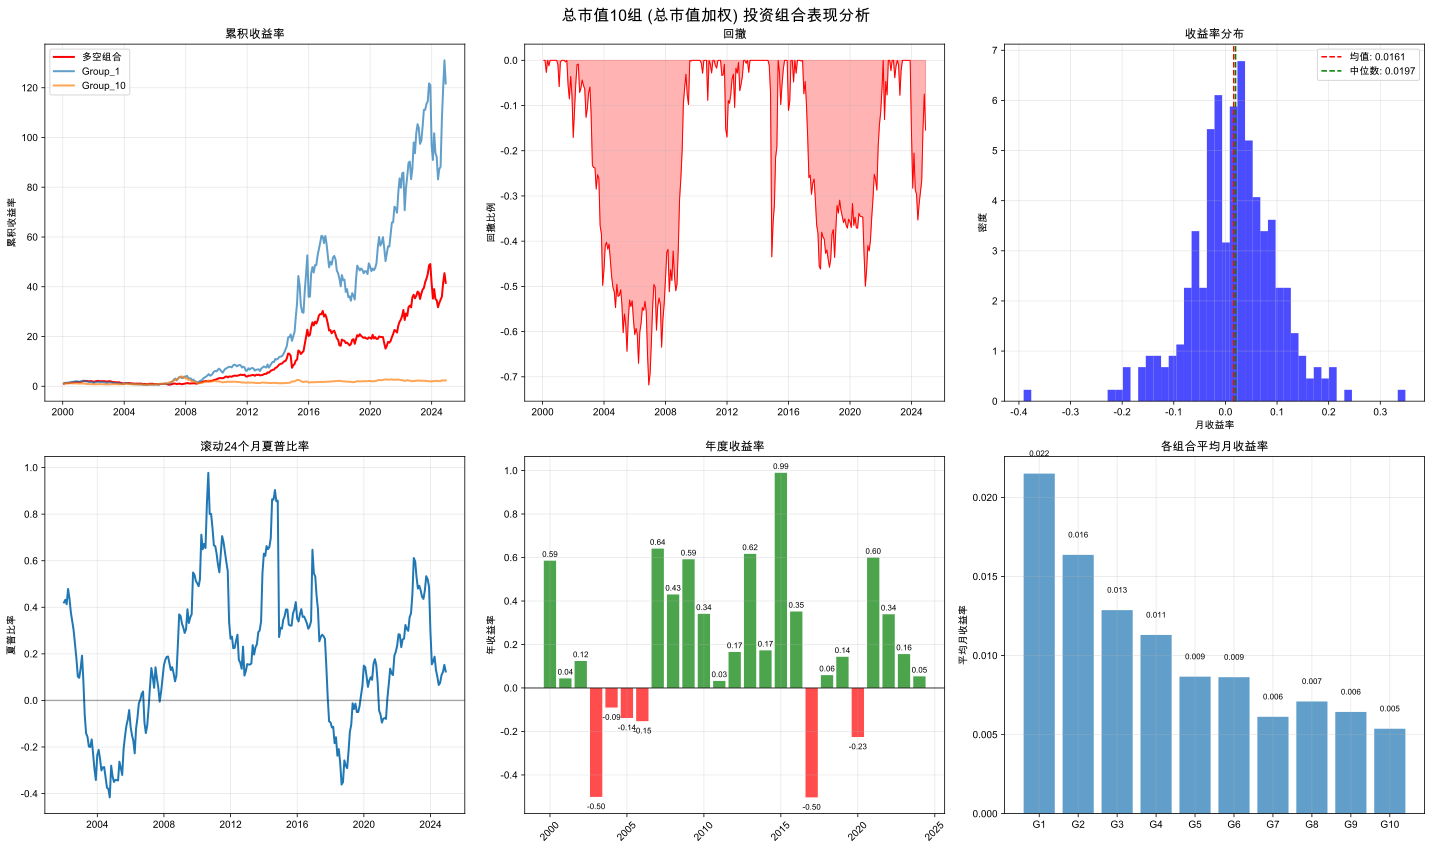

In [66]:
# 基于总市值的规模异象（指定时间范围）
print("=== 基于总市值(totalvalue)的规模异象 ===")
size_portfolio_10 = construct_anomaly_portfolio(
    ret_mon, 
    'totalvalue', 
    n_groups=10, 
    ascending=True,
    weight_method='totalvalue',
    start_date='2000-01-01',  # 从2000年开始
    end_date='2024-12-31'     # 到2023年结束
)

size_stats_10 = analyze_portfolio_performance(
    size_portfolio_10, 
    "总市值10组", 
    start_date='2000-01-01',
    end_date='2024-12-31',
    weight_method='totalvalue',
    plot_cumulative=True
)

# 反转 Reversal

=== 基于反转(ret)的规模异象 ===

总市值10组 投资组合分析报告
加权方法: 总市值加权
分析期间: 2000-01 至 2024-11

=== 基本统计信息 ===
          Group_1     Group_2     Group_3     Group_4     Group_5     Group_6  \
count  299.000000  299.000000  299.000000  299.000000  299.000000  299.000000   
mean     0.008318    0.010076    0.009652    0.007861    0.010252    0.008616   
std      0.089881    0.086300    0.077900    0.077378    0.082145    0.080276   
min     -0.291110   -0.293801   -0.251438   -0.234399   -0.302977   -0.267823   
25%     -0.044501   -0.042083   -0.040480   -0.040641   -0.038553   -0.039539   
50%      0.006419    0.006411    0.007800    0.007215    0.008444    0.006693   
75%      0.051676    0.052669    0.052786    0.044296    0.049375    0.048251   
max      0.305230    0.322787    0.275616    0.307480    0.359032    0.285895   

          Group_7     Group_8     Group_9    Group_10  Long_Short  
count  299.000000  299.000000  299.000000  299.000000  299.000000  
mean     0.009099    0.007069    0.005602 

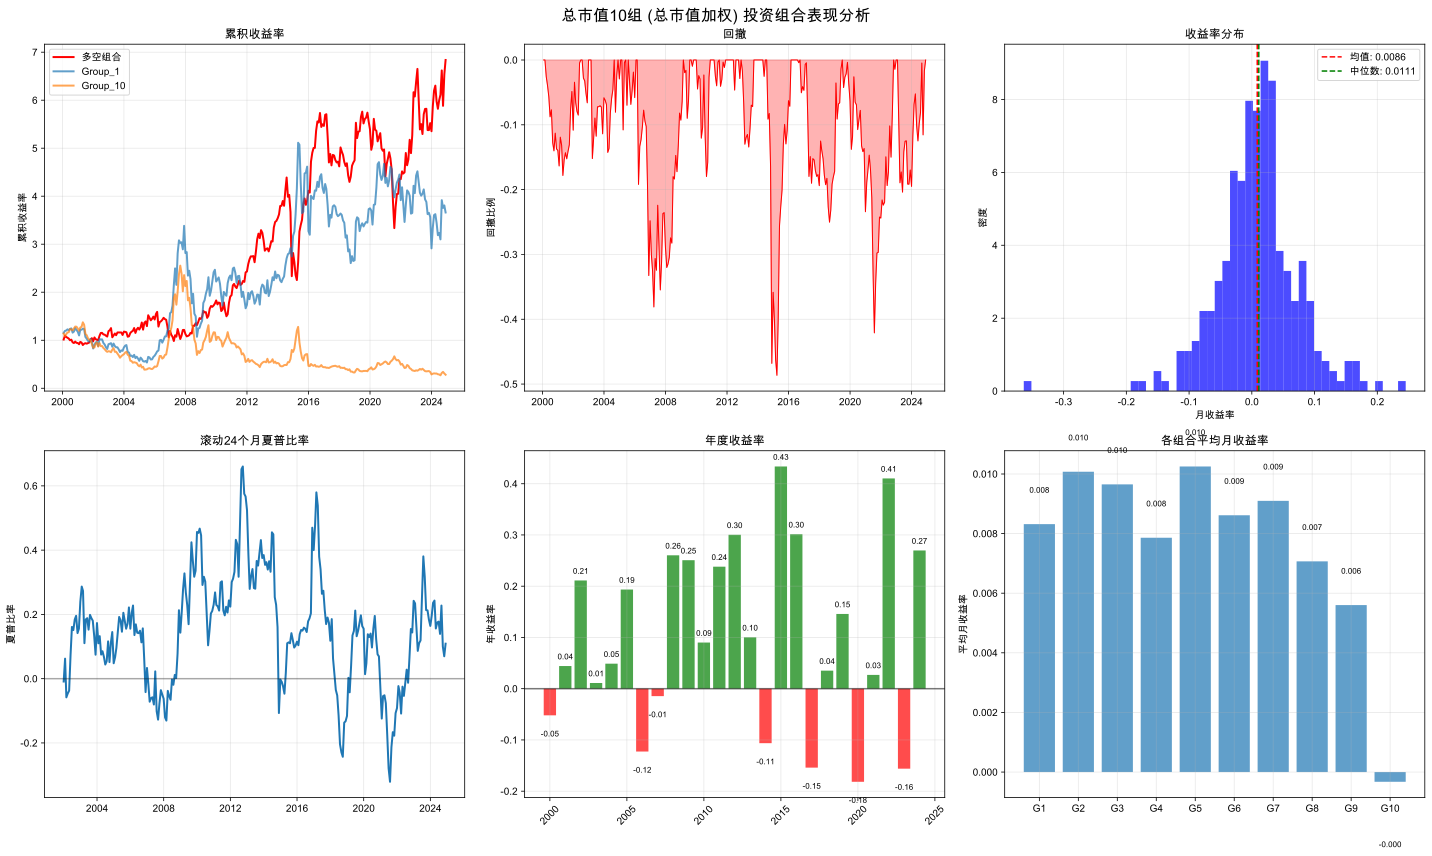

In [71]:
# 基于本月收益率的规模异象（指定时间范围）
print("=== 基于反转(ret)的规模异象 ===")
reversal_portfolio_10 = construct_anomaly_portfolio(
    ret_mon, 
    'ret', 
    n_groups=10, 
    ascending=True,
    weight_method='totalvalue',
    start_date='2000-01-01',  # 从2000年开始
    end_date='2024-12-31'     # 到2023年结束
)

reversal_portfolio_10 = analyze_portfolio_performance(
    reversal_portfolio_10, 
    "总市值10组", 
    start_date='2000-01-01',
    end_date='2024-12-31',
    weight_method='totalvalue',
    plot_cumulative=True
)

# 动量 Momentum

In [70]:
# 计算动量因子（t-1月到t-12月的累计收益率）
print("开始计算动量因子...")

# 首先为每个股票创建过去1-12个月的收益率列
for i in range(1, 13):  # t-1 到 t-12
    # 创建一个临时列，将月份向后移动i个月
    ret_mon[f'past_month_{i}'] = ret_mon['month'].dt.to_period('M').dt.to_timestamp('M')
    ret_mon[f'past_month_{i}'] = ret_mon[f'past_month_{i}'] - pd.DateOffset(months=i) + MonthEnd(0)
    
    # 使用merge来匹配过去月份的收益率
    past_returns = ret_mon[['Stkcd', 'month', 'ret']].copy()
    past_returns['month'] = past_returns['month'].dt.to_period('M').dt.to_timestamp('M')
    past_returns = past_returns.rename(
        columns={'month': f'past_month_{i}', 'ret': f'ret_t_minus_{i}'}
    )
    
    # 将过去收益率合并到原始数据中
    ret_mon = ret_mon.merge(
        past_returns,
        on=['Stkcd', f'past_month_{i}'],
        how='left'
    )
    
    # 删除临时列
    ret_mon = ret_mon.drop(columns=[f'past_month_{i}'])

print("过去收益率列创建完成")

# 计算动量因子（t-1到t-12月的累计收益率）
momentum_cols = [f'ret_t_minus_{i}' for i in range(1, 13)]

def calculate_momentum(row):
    """计算单行的动量因子"""
    returns = []
    for col in momentum_cols:
        if pd.notna(row[col]):
            returns.append(row[col])
    
    # 至少需要6个月的数据
    if len(returns) >= 6:
        # 计算累计收益率: (1+r1)*(1+r2)*...*(1+rn) - 1
        momentum = np.prod([1 + r for r in returns]) - 1
        return momentum
    else:
        return np.nan

# 应用动量计算函数
ret_mon['momentum'] = ret_mon.apply(calculate_momentum, axis=1)

print("动量因子计算完成")
print(f"动量因子非空值数量: {ret_mon['momentum'].notna().sum()}")
print(f"总观测数: {len(ret_mon)}")
print(f"动量因子覆盖率: {ret_mon['momentum'].notna().sum() / len(ret_mon):.2%}")

print("\n动量因子描述性统计:")
print(ret_mon['momentum'].describe())

# 显示结果
ret_mon[['Stkcd', 'month', 'momentum'] + momentum_cols[:5]].head(20)

开始计算动量因子...
过去收益率列创建完成
动量因子计算完成
动量因子非空值数量: 668442
总观测数: 701288
动量因子覆盖率: 95.32%

动量因子描述性统计:
count    668442.000000
mean          0.113277
std           0.619892
min          -0.976849
25%          -0.239547
50%          -0.036274
75%           0.264994
max          18.157006
Name: momentum, dtype: float64


,Stkcd,month,momentum,ret_t_minus_1,ret_t_minus_2,ret_t_minus_3,ret_t_minus_4,ret_t_minus_5
0,000001,1992-04-30,NaN,NaN,NaN,NaN,NaN,NaN
1,000001,1992-05-31,NaN,0.471835,NaN,NaN,NaN,NaN
2,000001,1992-06-30,NaN,0.167934,0.471835,NaN,NaN,NaN
3,000001,1992-07-31,NaN,-0.076888,0.167934,0.471835,NaN,NaN
4,000001,1992-08-31,NaN,0.079622,-0.076888,0.167934,0.471835,NaN
5,000001,1992-09-30,NaN,-0.101487,0.079622,-0.076888,0.167934,0.471835
6,000001,1992-10-31,0.654950,0.075120,-0.101487,0.079622,-0.076888,0.167934
7,000001,1992-11-30,0.472323,-0.110352,0.075120,-0.101487,0.079622,-0.076888
8,000001,1992-12-31,0.402544,-0.047394,-0.110352,0.075120,-0.101487,0.079622
9,000001,1993-01-31,0.621043,0.155788,-0.047394,-0.110352,0.075120,-0.101487


=== 基于动量(momentum)的规模异象 ===

动量10组 投资组合分析报告
加权方法: 总市值加权
分析期间: 2000-01 至 2024-11

=== 基本统计信息 ===
          Group_1     Group_2     Group_3     Group_4     Group_5     Group_6  \
count  299.000000  299.000000  299.000000  299.000000  299.000000  299.000000   
mean     0.004671    0.004178    0.005746    0.007618    0.008044    0.006705   
std      0.083192    0.077629    0.076047    0.077368    0.079448    0.078043   
min     -0.317855   -0.301077   -0.284051   -0.257303   -0.274279   -0.291637   
25%     -0.041526   -0.037626   -0.032596   -0.037525   -0.041229   -0.038452   
50%      0.005175    0.005800    0.008639    0.006742    0.005929    0.005171   
75%      0.046353    0.041561    0.042172    0.047339    0.047599    0.043515   
max      0.317789    0.258500    0.305879    0.253727    0.288306    0.248119   

          Group_7     Group_8     Group_9    Group_10  Long_Short  
count  299.000000  299.000000  299.000000  299.000000  299.000000  
mean     0.005716    0.006650    0.007

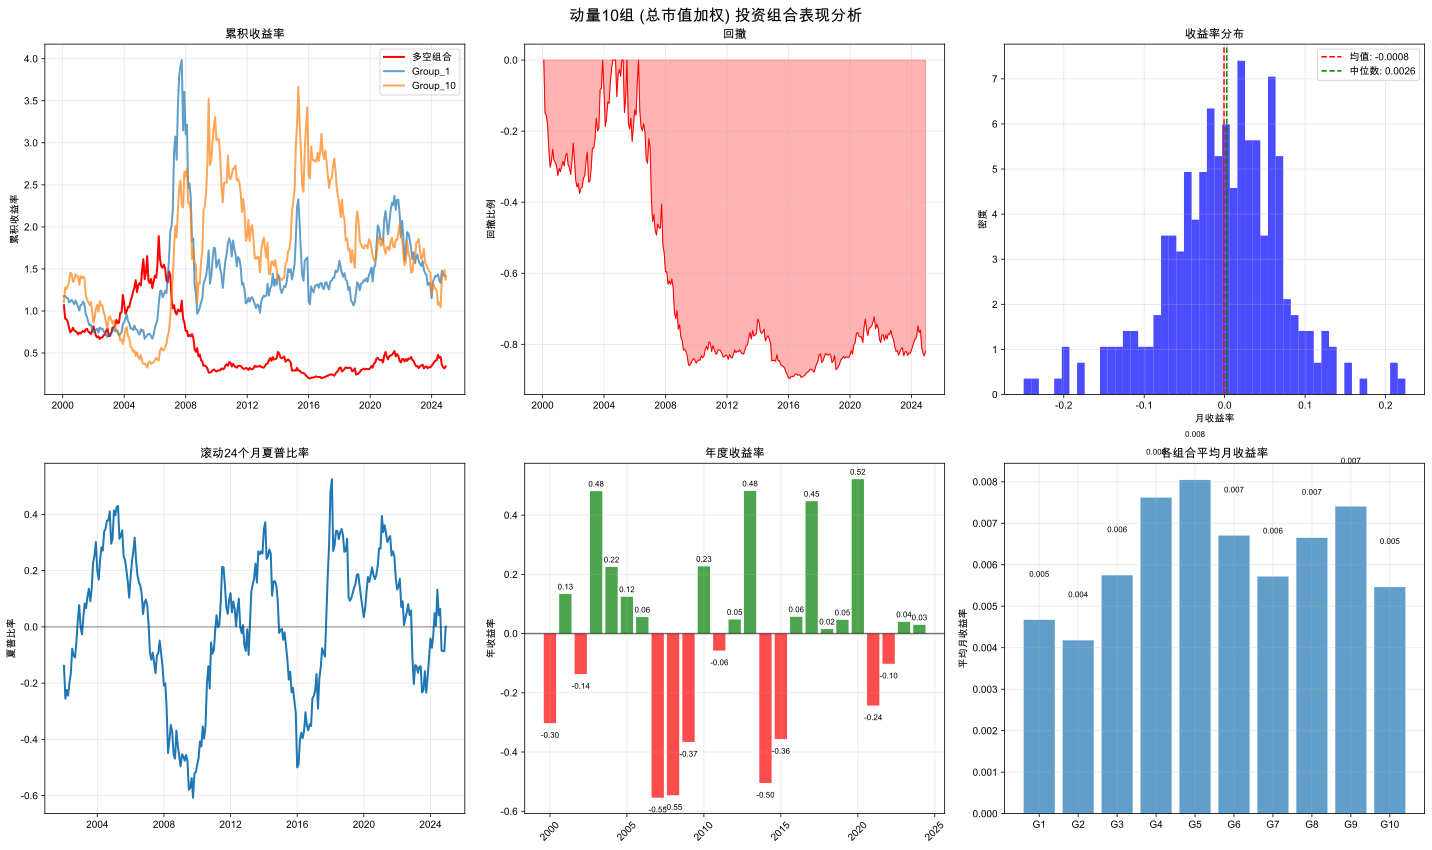

In [73]:
# 动量异象
print("=== 基于动量(momentum)的规模异象 ===")
momentum_portfolio_10 = construct_anomaly_portfolio(
    ret_mon, 
    'momentum', 
    n_groups=10, 
    ascending=False,  # 动量因子是降序排列
    weight_method='totalvalue',
    start_date='2000-01-01',  # 从2000年开始
    end_date='2024-12-31'     # 到2024年结束
)

momentum_portfolio_10 = analyze_portfolio_performance(
    momentum_portfolio_10, 
    "动量10组", 
    start_date='2000-01-01',
    end_date='2024-12-31',
    weight_method='totalvalue',
    plot_cumulative=True
)
